<a href="https://colab.research.google.com/github/wagner-alves-AI/PLN/blob/master/APP2_Wagner_Alves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Biblioteca para compatibilidade python 2 e 3
from __future__ import absolute_import, division, print_function

In [24]:
import re
import codecs
import glob
import pandas as pd
import gensim
import nltk
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from nltk.corpus import machado
nltk.download('machado')
nltk.download('punkt')

[nltk_data] Downloading package machado to /root/nltk_data...
[nltk_data]   Package machado is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
# Extrair e disponibilizar os textos dentro do ambiente
import zipfile
         
machado_zip = zipfile.ZipFile('/root/nltk_data/corpora/machado.zip')
machado_zip.extractall('/root/machado')
 
machado_zip.close()

In [29]:
# Varrer todos os títulos contídos em contos
livros_machado = sorted(glob.glob("/root/machado/machado/contos/*.txt"))

In [ ]:
# Imprimir as obras localizadas
print("livros encontrados:")
livros_machado

In [ ]:
# Etapa 1 da organização dos dados

# Concatenar todos os livros em uma única string
corpus_raw = u""

for livro_machado in livros_machado:
    print("Lendo '{0}'...".format(livro_machado))
    with open(livro_machado, "r",encoding="ISO-8859-1") as book_file:
        corpus_raw += book_file.read()
    print("O corpus possui agora {0} caracteres".format(len(corpus_raw)))
    print()

In [32]:
tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')

In [33]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [34]:
# Criar um wordlist e fazer uma remoção de caracteres desnecessários
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [35]:
# Tokenização
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [36]:
# Validação 
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Não há hesitação
possível: vou apresentar-lhes Miss Dollar.
['N', 'o', 'h', 'hesita', 'o', 'poss', 'vel', 'vou', 'apresentar', 'lhes', 'Miss', 'Dollar']


In [37]:
# Contagem dos tokens
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,012,724 tokens


In [38]:
# Etapa 2 - Construir o modelo
# Definir Hiperparâmetros

num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

In [39]:

machado2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [40]:
machado2vec.build_vocab(sentences)

In [41]:
print("Word2Vec vocabulary length:", len(machado2vec.wv.vocab))

Word2Vec vocabulary length: 16256


In [42]:
machado2vec.train(sentences, total_examples=machado2vec.corpus_count, epochs=3)

(2213457, 3038172)

In [43]:
# Salvar o modelo
if not os.path.exists("trained"):
    os.makedirs("trained")

In [44]:
machado2vec.save(os.path.join("trained", "machado2vec.w2v"))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [45]:
# Carregar modelo
machado2vec = w2v.Word2Vec.load(os.path.join("trained", "machado2vec.w2v"))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [46]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [47]:
all_word_vectors_matrix = machado2vec.wv.syn0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [48]:
# treinar o modelo  t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [51]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[machado2vec.wv.vocab[word].index])
            for word in machado2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [83]:
points.tail(50)

,word,x,y
16206,Almanaque,46.948483,29.368637
16207,Pha,-16.526026,13.578892
16208,Nohr,-16.541458,13.567510
16209,nfis,36.762512,-16.628775
16210,escriba,-7.313268,-0.273697
16211,Bachtan,22.072388,-38.747704
16212,Charmion,-22.622940,-9.642803
16213,Melchior,3.398311,-28.247978
16214,Legazinha,20.532415,14.554210
16215,acionistas,62.722534,-30.385130


In [53]:
sns.set_context("poster")

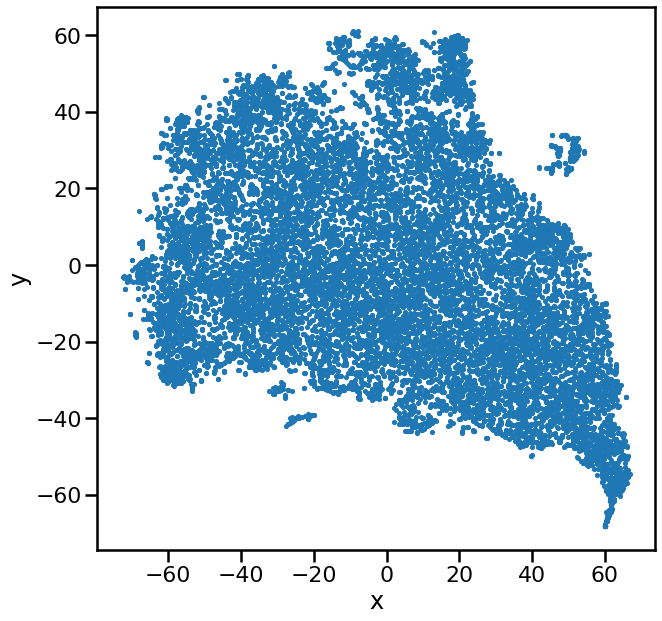

In [81]:
points.plot.scatter("x", "y", s=10, figsize=(10, 10))

In [84]:
machado2vec.most_similar("Finoca")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('admirada', 0.9779085516929626),
 ('maliciosamente', 0.9706838726997375),
 ('Ermelinda', 0.9700701236724854),
 ('envergonhada', 0.9697402715682983),
 ('gostou', 0.9693316221237183),
 ('resolutamente', 0.9686998128890991),
 ('Ypsilanti', 0.9673720598220825),
 ('repreendeu', 0.9667892456054688),
 ('acompanhasse', 0.9665701389312744),
 ('Alberta', 0.9654182195663452)]